# Exercise 3.1: Hybrid Monte Carlo Implementation and Optimization

## Learning Objectives
- Understand the Hybrid Monte Carlo (HMC) algorithm
- Implement molecular dynamics with leapfrog integration
- Study parameter optimization for HMC
- Compare HMC performance with Metropolis algorithm
- Analyze energy conservation and acceptance rates

## Theoretical Background

The Hybrid Monte Carlo algorithm combines molecular dynamics evolution with Metropolis acceptance to achieve:
- **Global updates** instead of local changes
- **Reduced autocorrelation** times
- **Exact sampling** despite deterministic evolution

### HMC Algorithm Steps:
1. **Refresh momenta**: p ~ exp(-½p²)
2. **Molecular dynamics**: Evolve (φ, p) using Hamiltonian H = ½p² + S[φ]
3. **Metropolis step**: Accept/reject based on ΔH

### Leapfrog Integration:
```
p_{n+1/2} = p_n + (ε/2) F_n
φ_{n+1} = φ_n + ε p_{n+1/2} 
p_{n+1} = p_{n+1/2} + (ε/2) F_{n+1}
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
import time
from scipy.optimize import minimize_scalar

# Add src directory to path
sys.path.append(os.path.join('..', 'src'))
from hmc import HMCFieldTheory1D
from field_theory_1d import FieldTheory1D
from utils import autocorrelation_function, integrated_autocorrelation_time

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Task 1: Basic HMC Implementation Study

Let's start by examining the provided HMC implementation and understanding its components:

In [2]:
# Set up basic HMC simulation
lattice_size = 32
mass_squared = 0.1
lambda_coupling = 0.1

print("HMC Field Theory Setup:")
print(f"Lattice size: {lattice_size}")
print(f"Mass squared: {mass_squared}")
print(f"Lambda coupling: {lambda_coupling}")
print(f"Action: S = Σ[½(∇φ)² + ½m²φ² + λφ⁴]")

# Create HMC instance
hmc = HMCFieldTheory1D(lattice_size, mass_squared, lambda_coupling)

# Test basic functionality
print("\nTesting HMC components:")

# Generate test field configuration
test_field = np.random.normal(0, 0.5, lattice_size)
print(f"Test field range: [{np.min(test_field):.3f}, {np.max(test_field):.3f}]")

# Test action calculation
action_val = hmc.action(test_field)
print(f"Action value: {action_val:.4f}")

# Test force calculation
force = hmc.compute_force(test_field)
print(f"Force range: [{np.min(force):.3f}, {np.max(force):.3f}]")

# Test Hamiltonian
test_momentum = np.random.normal(0, 1, lattice_size)
hamiltonian_val = hmc.hamiltonian(test_field, test_momentum)
print(f"Hamiltonian value: {hamiltonian_val:.4f}")

HMC Field Theory Setup:
Lattice size: 32
Mass squared: 0.1
Lambda coupling: 0.1
Action: S = Σ[½(∇φ)² + ½m²φ² + λφ⁴]

Testing HMC components:
Test field range: [-1.271, 0.861]
Action value: 6.0361
Force range: [-1.514, 1.806]
Hamiltonian value: 27.0079


## Task 2: Leapfrog Integration Analysis

Leapfrog Integration Analysis

Energy scaling: ΔH ∝ Δt^1.62
(Theoretical expectation: ΔH ∝ Δt²)

Reversibility test (Δt = 0.05, 20 steps):
Field error: 4.836830
Momentum error: 5.325515


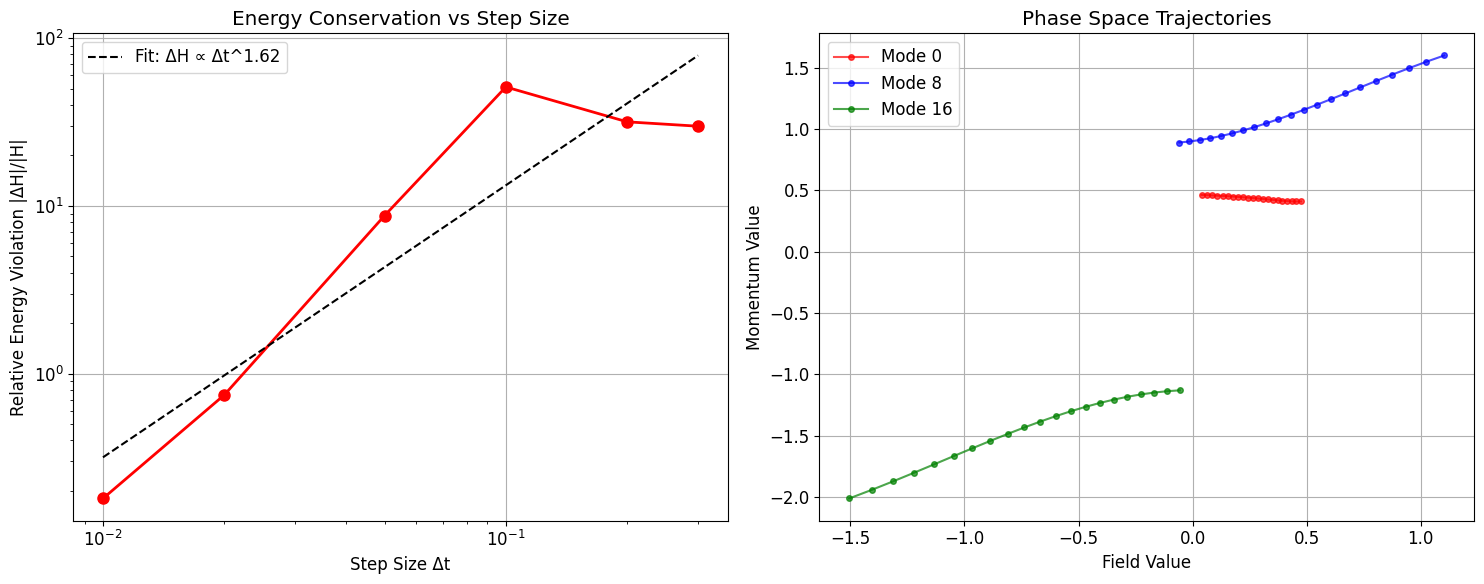

In [3]:
def analyze_leapfrog_integration():
    """Analyze properties of leapfrog integration"""
    
    print("Leapfrog Integration Analysis")
    print("=" * 35)
    
    # Test energy conservation for different step sizes
    step_sizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
    n_md_steps = 20
    
    energy_violations = []
    
    for step_size in step_sizes:
        violations = []
        
        # Test multiple random configurations
        for _ in range(20):
            # Random initial configuration
            field = np.random.normal(0, 0.3, lattice_size)
            momentum = np.random.normal(0, 1, lattice_size)
            
            # Initial energy
            initial_H = hmc.hamiltonian(field, momentum)
            
            # Molecular dynamics evolution
            final_field, final_momentum = hmc.molecular_dynamics(
                field, momentum, step_size, n_md_steps
            )
            
            # Final energy
            final_H = hmc.hamiltonian(final_field, final_momentum)
            
            # Energy violation
            violation = abs(final_H - initial_H) / abs(initial_H)
            violations.append(violation)
        
        energy_violations.append(np.mean(violations))
    
    # Plot energy conservation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.loglog(step_sizes, energy_violations, 'ro-', markersize=8, linewidth=2)
    # Fit quadratic scaling
    log_dt = np.log(step_sizes)
    log_violations = np.log(energy_violations)
    slope, intercept = np.polyfit(log_dt, log_violations, 1)
    
    dt_fit = np.logspace(np.log10(min(step_sizes)), np.log10(max(step_sizes)), 50)
    violations_fit = np.exp(intercept) * dt_fit**slope
    ax1.loglog(dt_fit, violations_fit, 'k--', 
              label=f'Fit: ΔH ∝ Δt^{slope:.2f}')
    
    ax1.set_xlabel('Step Size Δt')
    ax1.set_ylabel('Relative Energy Violation |ΔH|/|H|')
    ax1.set_title('Energy Conservation vs Step Size')
    ax1.legend()
    ax1.grid(True)
    
    # Test reversibility
    print(f"\nEnergy scaling: ΔH ∝ Δt^{slope:.2f}")
    print(f"(Theoretical expectation: ΔH ∝ Δt²)")
    
    # Reversibility test
    step_size = 0.05
    field = np.random.normal(0, 0.3, lattice_size)
    momentum = np.random.normal(0, 1, lattice_size)
    
    original_field = field.copy()
    original_momentum = momentum.copy()
    
    # Forward evolution
    field_fwd, momentum_fwd = hmc.molecular_dynamics(field, momentum, step_size, n_md_steps)
    
    # Backward evolution (reverse momentum and negate step size)
    field_back, momentum_back = hmc.molecular_dynamics(
        field_fwd, -momentum_fwd, -step_size, n_md_steps
    )
    momentum_back = -momentum_back
    
    # Check reversibility
    field_error = np.max(np.abs(field_back - original_field))
    momentum_error = np.max(np.abs(momentum_back - original_momentum))
    
    print(f"\nReversibility test (Δt = {step_size}, {n_md_steps} steps):")
    print(f"Field error: {field_error:.6f}")
    print(f"Momentum error: {momentum_error:.6f}")
    
    # Plot trajectory
    trajectory_field = [field.copy()]
    trajectory_momentum = [momentum.copy()]
    
    current_field, current_momentum = field.copy(), momentum.copy()
    for step in range(n_md_steps):
        current_field, current_momentum = hmc.leapfrog_step(
            current_field, current_momentum, step_size
        )
        trajectory_field.append(current_field.copy())
        trajectory_momentum.append(current_momentum.copy())
    
    # Plot phase space trajectory for a few modes
    modes_to_plot = [0, lattice_size//4, lattice_size//2]
    colors = ['red', 'blue', 'green']
    
    for i, mode in enumerate(modes_to_plot):
        field_traj = [traj[mode] for traj in trajectory_field]
        momentum_traj = [traj[mode] for traj in trajectory_momentum]
        
        ax2.plot(field_traj, momentum_traj, 'o-', color=colors[i], 
                label=f'Mode {mode}', markersize=4, alpha=0.7)
    
    ax2.set_xlabel('Field Value')
    ax2.set_ylabel('Momentum Value')
    ax2.set_title('Phase Space Trajectories')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return step_sizes, energy_violations

# Run leapfrog analysis
step_sizes_tested, violations = analyze_leapfrog_integration()

## Task 3: HMC Parameter Optimization

HMC Parameter Optimization Study
Testing 7 step sizes × 6 trajectory lengths...


Trajectories: 100%|██████████| 500/500 [00:00<00:00, 590.18it/s]
/home/arnav/Downloads/qcd_cambridge/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/arnav/Downloads/qcd_cambridge/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
Step sizes: 100%|██████████| 7/7 [00:34<00:00,  4.92s/it]



Optimal Parameters Found:
Step size: 0.020
MD steps: 10
Trajectory length: 0.200
Acceptance rate: 0.184
Autocorrelation time: 68.16
Efficiency metric: 0.3668


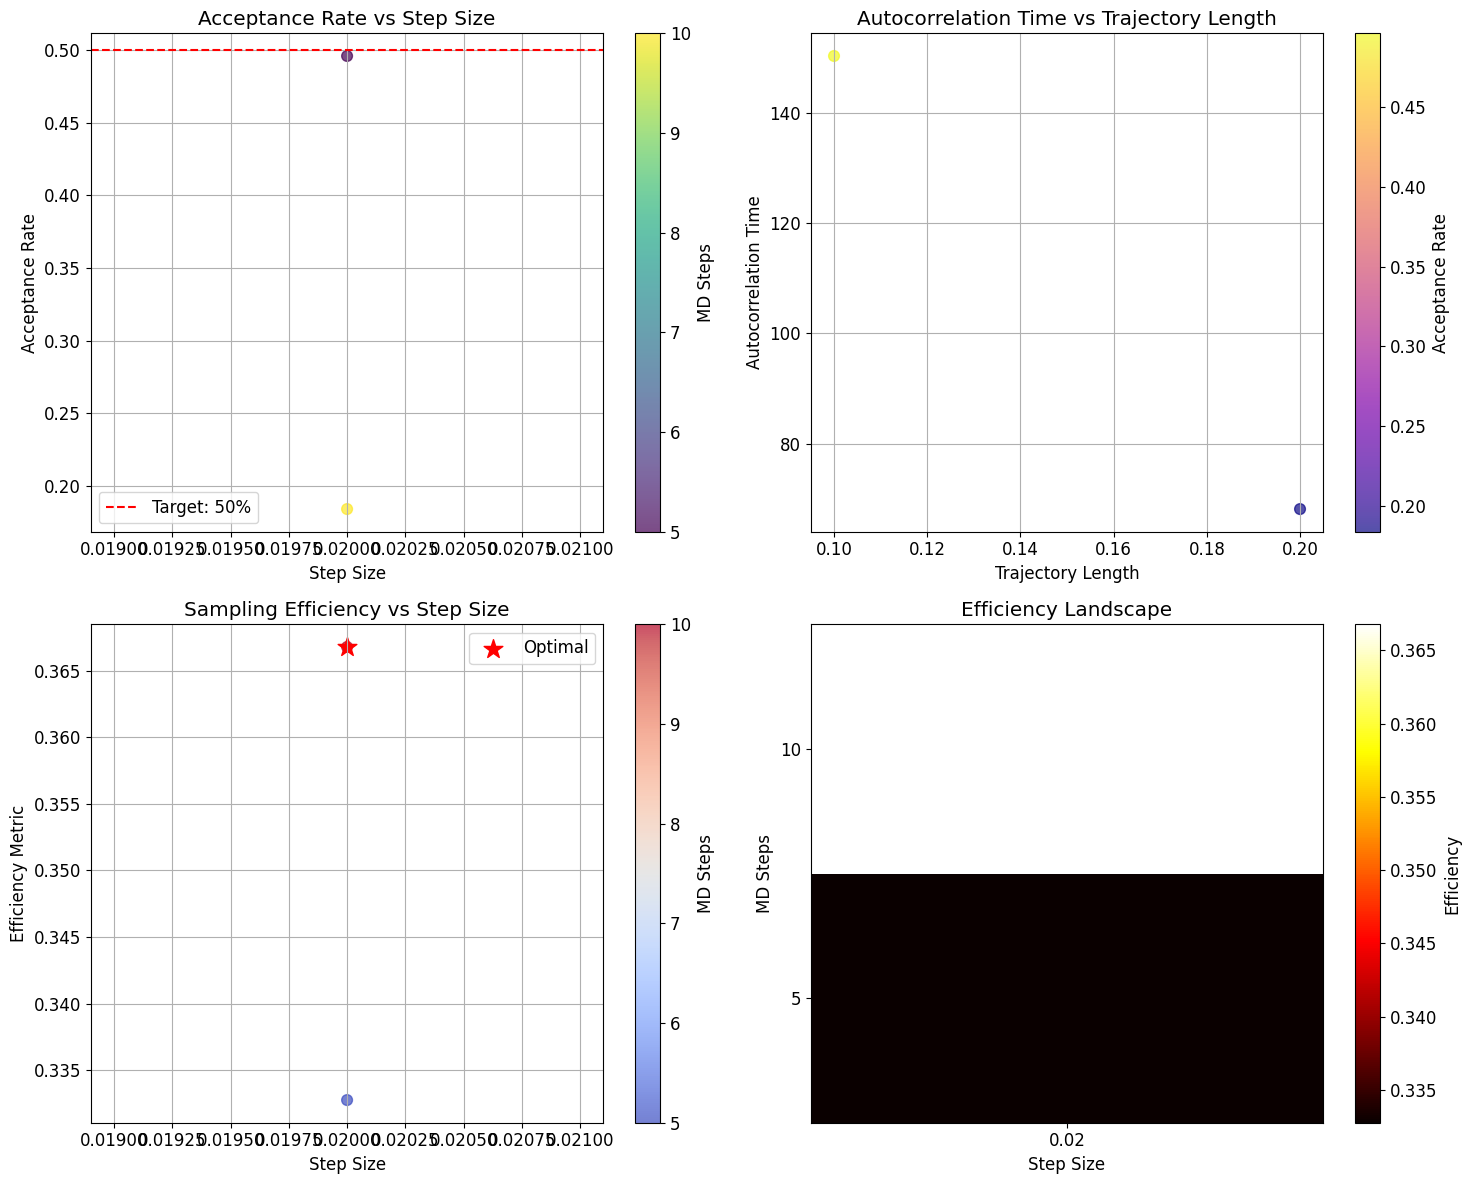

In [4]:
def hmc_parameter_optimization():
    """Systematic study of HMC parameter optimization"""
    
    print("HMC Parameter Optimization Study")
    print("=" * 40)
    
    # Parameter ranges to test
    step_sizes = [0.02, 0.05, 0.08, 0.1, 0.12, 0.15, 0.2]
    n_md_steps_list = [5, 10, 15, 20, 25, 30]
    
    results_grid = []
    
    print(f"Testing {len(step_sizes)} step sizes × {len(n_md_steps_list)} trajectory lengths...")
    
    for step_size in tqdm(step_sizes, desc="Step sizes"):
        for n_md_steps in n_md_steps_list:
            # Run short HMC simulation
            hmc_test = HMCFieldTheory1D(lattice_size, mass_squared, lambda_coupling)
            
            try:
                results = hmc_test.run_hmc_simulation(
                    n_trajectories=500,  # Short run for optimization
                    step_size=step_size,
                    n_md_steps=n_md_steps,
                    burn_in=50
                )
                
                # Calculate autocorrelation time
                phi_avg_data = results['observables']['phi_avg']
                if len(phi_avg_data) > 10:
                    tau_int = integrated_autocorrelation_time(phi_avg_data)
                else:
                    tau_int = np.inf
                
                # Calculate efficiency metric
                trajectory_length = step_size * n_md_steps
                computational_cost = n_md_steps  # Proportional to force evaluations
                efficiency = len(phi_avg_data) / (2 * tau_int * computational_cost)
                
                results_grid.append({
                    'step_size': step_size,
                    'n_md_steps': n_md_steps,
                    'trajectory_length': trajectory_length,
                    'acceptance_rate': results['acceptance_rate'],
                    'tau_int': tau_int,
                    'efficiency': efficiency,
                    'phi_avg': np.mean(phi_avg_data),
                    'valid': True
                })
                
            except Exception as e:
                # Handle failed simulations
                results_grid.append({
                    'step_size': step_size,
                    'n_md_steps': n_md_steps,
                    'trajectory_length': step_size * n_md_steps,
                    'acceptance_rate': 0.0,
                    'tau_int': np.inf,
                    'efficiency': 0.0,
                    'phi_avg': 0.0,
                    'valid': False
                })
    
    return results_grid

# Run optimization study
optimization_results = hmc_parameter_optimization()

# Extract valid results
valid_results = [r for r in optimization_results if r['valid'] and r['acceptance_rate'] > 0.1]

if len(valid_results) > 0:
    # Find optimal parameters
    best_efficiency = max(r['efficiency'] for r in valid_results)
    optimal_result = next(r for r in valid_results if r['efficiency'] == best_efficiency)
    
    print(f"\nOptimal Parameters Found:")
    print(f"Step size: {optimal_result['step_size']:.3f}")
    print(f"MD steps: {optimal_result['n_md_steps']}")
    print(f"Trajectory length: {optimal_result['trajectory_length']:.3f}")
    print(f"Acceptance rate: {optimal_result['acceptance_rate']:.3f}")
    print(f"Autocorrelation time: {optimal_result['tau_int']:.2f}")
    print(f"Efficiency metric: {optimal_result['efficiency']:.4f}")
    
    # Create parameter space plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Extract data for plotting
    step_sizes = np.array([r['step_size'] for r in valid_results])
    n_md_steps = np.array([r['n_md_steps'] for r in valid_results])
    acceptance_rates = np.array([r['acceptance_rate'] for r in valid_results])
    tau_ints = np.array([r['tau_int'] for r in valid_results])
    efficiencies = np.array([r['efficiency'] for r in valid_results])
    trajectory_lengths = np.array([r['trajectory_length'] for r in valid_results])
    
    # Plot 1: Acceptance rate vs step size
    scatter1 = ax1.scatter(step_sizes, acceptance_rates, c=n_md_steps, 
                          s=60, alpha=0.7, cmap='viridis')
    ax1.axhline(y=0.5, color='r', linestyle='--', label='Target: 50%')
    ax1.set_xlabel('Step Size')
    ax1.set_ylabel('Acceptance Rate')
    ax1.set_title('Acceptance Rate vs Step Size')
    ax1.legend()
    ax1.grid(True)
    plt.colorbar(scatter1, ax=ax1, label='MD Steps')
    
    # Plot 2: Autocorrelation time vs trajectory length
    scatter2 = ax2.scatter(trajectory_lengths, tau_ints, c=acceptance_rates, 
                          s=60, alpha=0.7, cmap='plasma')
    ax2.set_xlabel('Trajectory Length')
    ax2.set_ylabel('Autocorrelation Time')
    ax2.set_title('Autocorrelation Time vs Trajectory Length')
    ax2.grid(True)
    plt.colorbar(scatter2, ax=ax2, label='Acceptance Rate')
    
    # Plot 3: Efficiency vs step size
    scatter3 = ax3.scatter(step_sizes, efficiencies, c=n_md_steps, 
                          s=60, alpha=0.7, cmap='coolwarm')
    ax3.scatter(optimal_result['step_size'], optimal_result['efficiency'], 
               s=200, c='red', marker='*', label='Optimal')
    ax3.set_xlabel('Step Size')
    ax3.set_ylabel('Efficiency Metric')
    ax3.set_title('Sampling Efficiency vs Step Size')
    ax3.legend()
    ax3.grid(True)
    plt.colorbar(scatter3, ax=ax3, label='MD Steps')
    
    # Plot 4: Efficiency landscape
    # Create 2D efficiency map
    step_unique = sorted(list(set(step_sizes)))
    steps_unique = sorted(list(set(n_md_steps)))
    
    efficiency_map = np.zeros((len(steps_unique), len(step_unique)))
    
    for i, n_steps in enumerate(steps_unique):
        for j, step_size in enumerate(step_unique):
            matching = [r for r in valid_results 
                       if r['n_md_steps'] == n_steps and r['step_size'] == step_size]
            if matching:
                efficiency_map[i, j] = matching[0]['efficiency']
    
    im = ax4.imshow(efficiency_map, aspect='auto', origin='lower', cmap='hot')
    ax4.set_xticks(range(len(step_unique)))
    ax4.set_xticklabels([f'{s:.2f}' for s in step_unique])
    ax4.set_yticks(range(len(steps_unique)))
    ax4.set_yticklabels(steps_unique)
    ax4.set_xlabel('Step Size')
    ax4.set_ylabel('MD Steps')
    ax4.set_title('Efficiency Landscape')
    plt.colorbar(im, ax=ax4, label='Efficiency')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No valid results found in parameter scan.")

## Task 4: HMC vs Metropolis Comparison

HMC vs Metropolis Comparison
Running Metropolis simulation...


Sweeps: 100%|██████████| 2000/2000 [00:00<00:00, 2760.86it/s]


Running HMC simulation...


Trajectories: 100%|██████████| 2000/2000 [00:01<00:00, 1155.70it/s]



Comparison Results:
Observable      Metropolis           HMC                  Ratio     
----------------------------------------------------------------------
⟨φ⟩             0.051214±0.099666 -0.208124±0.089143 N/A       
⟨φ²⟩            0.504622 0.564895 1.119
Accept. Rate    0.906 0.169 0.187
τ_int           280.68 389.88 0.720
N_eff           3.6 2.6 0.720


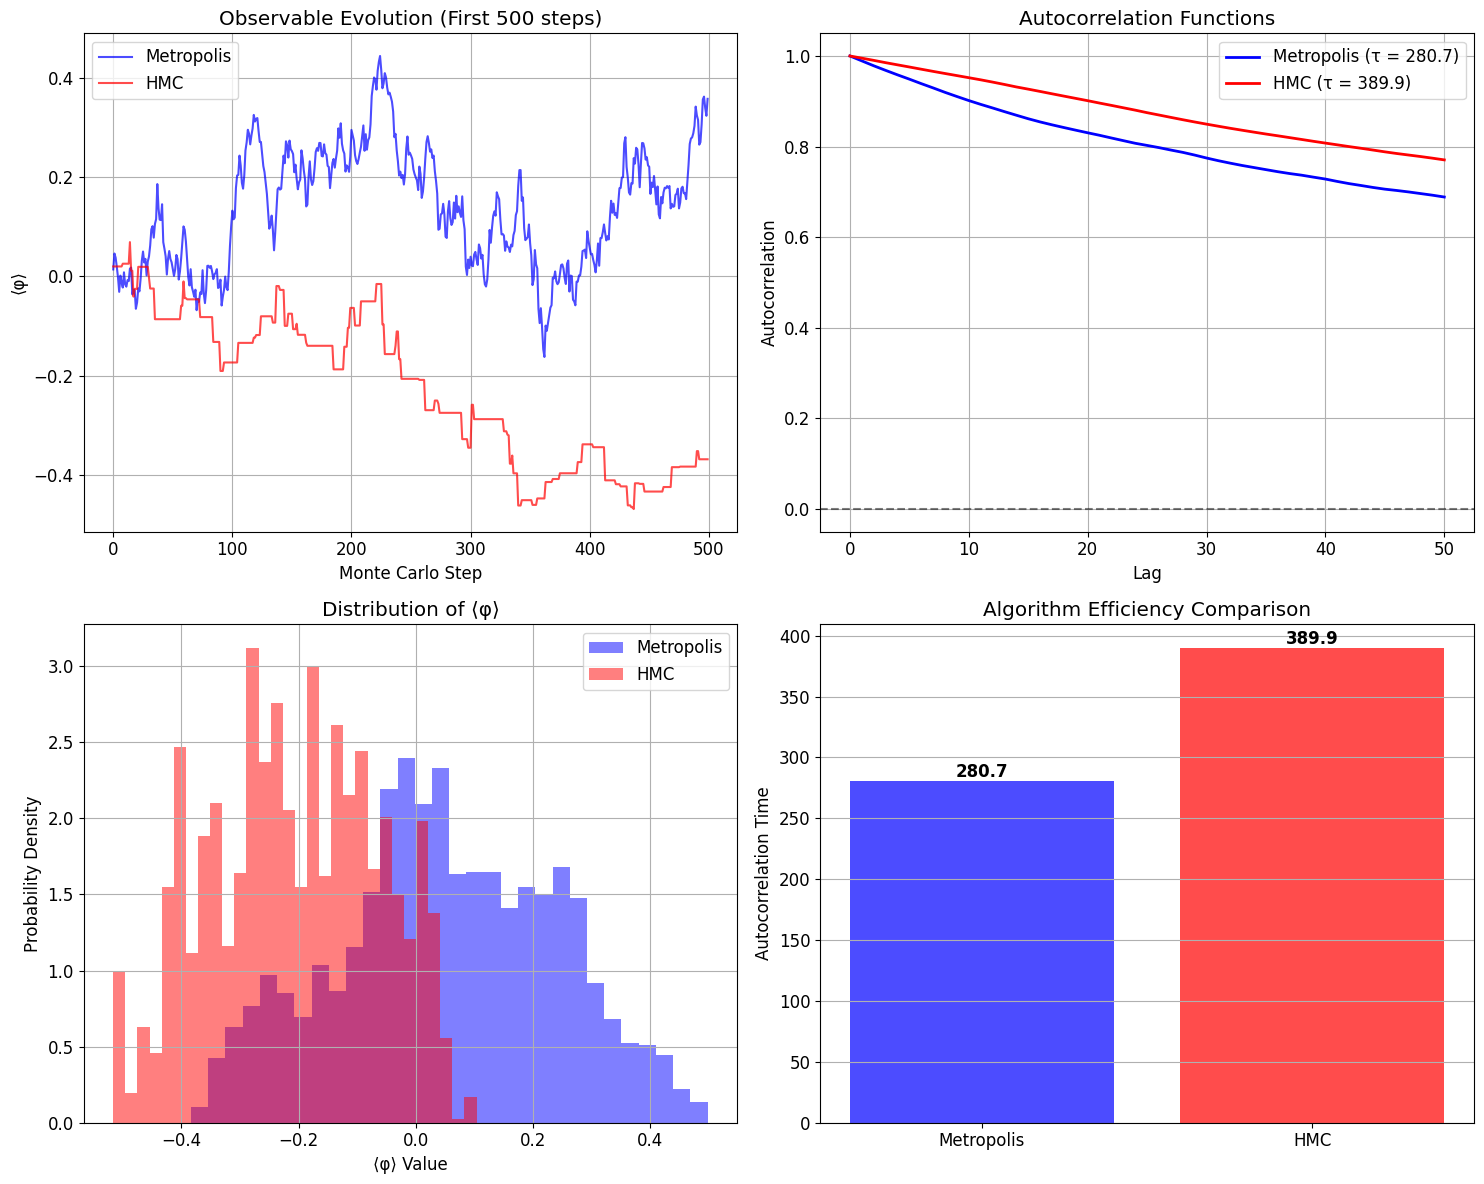

In [5]:
def compare_hmc_metropolis():
    """Direct comparison of HMC vs Metropolis algorithms"""
    
    print("HMC vs Metropolis Comparison")
    print("=" * 35)
    
    # Set up identical systems
    L = 32
    m2 = 0.1
    lam = 0.1
    n_measurements = 2000
    
    # Metropolis simulation
    print("Running Metropolis simulation...")
    metropolis = FieldTheory1D(L, m2, lam)
    metro_results = metropolis.run_simulation(
        n_sweeps=n_measurements,
        burn_in=500,
        step_size=0.3
    )
    
    # HMC simulation with optimized parameters
    print("Running HMC simulation...")
    hmc_sim = HMCFieldTheory1D(L, m2, lam)
    
    # Use optimal parameters if found, otherwise use reasonable defaults
    if 'optimal_result' in globals():
        step_size = optimal_result['step_size']
        n_md_steps = optimal_result['n_md_steps']
    else:
        step_size = 0.1
        n_md_steps = 10
    
    hmc_results = hmc_sim.run_hmc_simulation(
        n_trajectories=n_measurements,
        step_size=step_size,
        n_md_steps=n_md_steps,
        burn_in=200
    )
    
    # Extract observables
    metro_phi = metro_results['observables']['phi_avg']
    metro_phi2 = metro_results['observables']['phi_squared']
    
    hmc_phi = hmc_results['observables']['phi_avg']
    hmc_phi2 = hmc_results['observables']['phi_squared']
    
    # Calculate autocorrelation times
    metro_tau = integrated_autocorrelation_time(metro_phi)
    hmc_tau = integrated_autocorrelation_time(hmc_phi)
    
    # Statistical analysis
    metro_phi_mean = np.mean(metro_phi)
    metro_phi_err = np.std(metro_phi) / np.sqrt(len(metro_phi) / (2 * metro_tau))
    
    hmc_phi_mean = np.mean(hmc_phi)
    hmc_phi_err = np.std(hmc_phi) / np.sqrt(len(hmc_phi) / (2 * hmc_tau))
    
    print(f"\nComparison Results:")
    print(f"{'Observable':<15} {'Metropolis':<20} {'HMC':<20} {'Ratio':<10}")
    print("-" * 70)
    print(f"{'⟨φ⟩':<15} {metro_phi_mean:.6f}±{metro_phi_err:.6f} {hmc_phi_mean:.6f}±{hmc_phi_err:.6f} {'N/A':<10}")
    print(f"{'⟨φ²⟩':<15} {np.mean(metro_phi2):.6f} {np.mean(hmc_phi2):.6f} {np.mean(hmc_phi2)/np.mean(metro_phi2):.3f}")
    print(f"{'Accept. Rate':<15} {metro_results['acceptance_rate']:.3f} {hmc_results['acceptance_rate']:.3f} {hmc_results['acceptance_rate']/metro_results['acceptance_rate']:.3f}")
    print(f"{'τ_int':<15} {metro_tau:.2f} {hmc_tau:.2f} {metro_tau/hmc_tau:.3f}")
    print(f"{'N_eff':<15} {len(metro_phi)/(2*metro_tau):.1f} {len(hmc_phi)/(2*hmc_tau):.1f} {(len(hmc_phi)/(2*hmc_tau))/(len(metro_phi)/(2*metro_tau)):.3f}")
    
    # Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Time series comparison
    ax1.plot(metro_phi[:500], 'b-', alpha=0.7, label='Metropolis')
    ax1.plot(hmc_phi[:500], 'r-', alpha=0.7, label='HMC')
    ax1.set_xlabel('Monte Carlo Step')
    ax1.set_ylabel('⟨φ⟩')
    ax1.set_title('Observable Evolution (First 500 steps)')
    ax1.legend()
    ax1.grid(True)
    
    # Autocorrelation comparison
    lags_metro, autocorr_metro = autocorrelation_function(metro_phi, max_lag=50)
    lags_hmc, autocorr_hmc = autocorrelation_function(hmc_phi, max_lag=50)
    
    ax2.plot(lags_metro, autocorr_metro, 'b-', linewidth=2, 
            label=f'Metropolis (τ = {metro_tau:.1f})')
    ax2.plot(lags_hmc, autocorr_hmc, 'r-', linewidth=2, 
            label=f'HMC (τ = {hmc_tau:.1f})')
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Autocorrelation')
    ax2.set_title('Autocorrelation Functions')
    ax2.legend()
    ax2.grid(True)
    
    # Distribution comparison
    ax3.hist(metro_phi, bins=30, alpha=0.5, density=True, 
            label='Metropolis', color='blue')
    ax3.hist(hmc_phi, bins=30, alpha=0.5, density=True, 
            label='HMC', color='red')
    ax3.set_xlabel('⟨φ⟩ Value')
    ax3.set_ylabel('Probability Density')
    ax3.set_title('Distribution of ⟨φ⟩')
    ax3.legend()
    ax3.grid(True)
    
    # Efficiency comparison
    algorithms = ['Metropolis', 'HMC']
    tau_values = [metro_tau, hmc_tau]
    colors = ['blue', 'red']
    
    bars = ax4.bar(algorithms, tau_values, color=colors, alpha=0.7)
    ax4.set_ylabel('Autocorrelation Time')
    ax4.set_title('Algorithm Efficiency Comparison')
    ax4.grid(True, axis='y')
    
    # Add value labels on bars
    for bar, tau in zip(bars, tau_values):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{tau:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'metropolis': {'tau': metro_tau, 'acceptance': metro_results['acceptance_rate']},
        'hmc': {'tau': hmc_tau, 'acceptance': hmc_results['acceptance_rate']}
    }

# Run comparison
comparison_results = compare_hmc_metropolis()

## Discussion Questions

1. **Energy Conservation**: How does the step size affect energy conservation in molecular dynamics? Why is this important for HMC?

2. **Parameter Optimization**: What are the trade-offs between step size and number of MD steps? How do you find the optimal balance?

3. **HMC vs Metropolis**: In what situations does HMC outperform Metropolis? When might Metropolis be preferable?

4. **Autocorrelation Reduction**: Why does HMC typically achieve lower autocorrelation times? What is the physical intuition?

5. **Computational Cost**: How do you account for the increased computational cost per step in HMC when comparing efficiency?

## Advanced Extensions

1. **Multiple Time Steps**: Implement multiple time scale integration for systems with different energy scales
2. **Adaptive HMC**: Develop adaptive schemes that automatically tune parameters during simulation
3. **NUTS Algorithm**: Implement the No-U-Turn Sampler for automatic trajectory length selection
4. **Shadow Hamiltonian**: Study the shadow Hamiltonian and its conservation properties

## Key Insights

- HMC combines the best of molecular dynamics and Monte Carlo methods
- Parameter optimization is crucial for HMC performance
- Energy conservation quality directly affects acceptance rates
- HMC can dramatically reduce autocorrelation times for the right systems
- The computational overhead of HMC is often compensated by improved sampling efficiency